In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from matplotlib import ticker
from matplotlib import dates as mdates

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

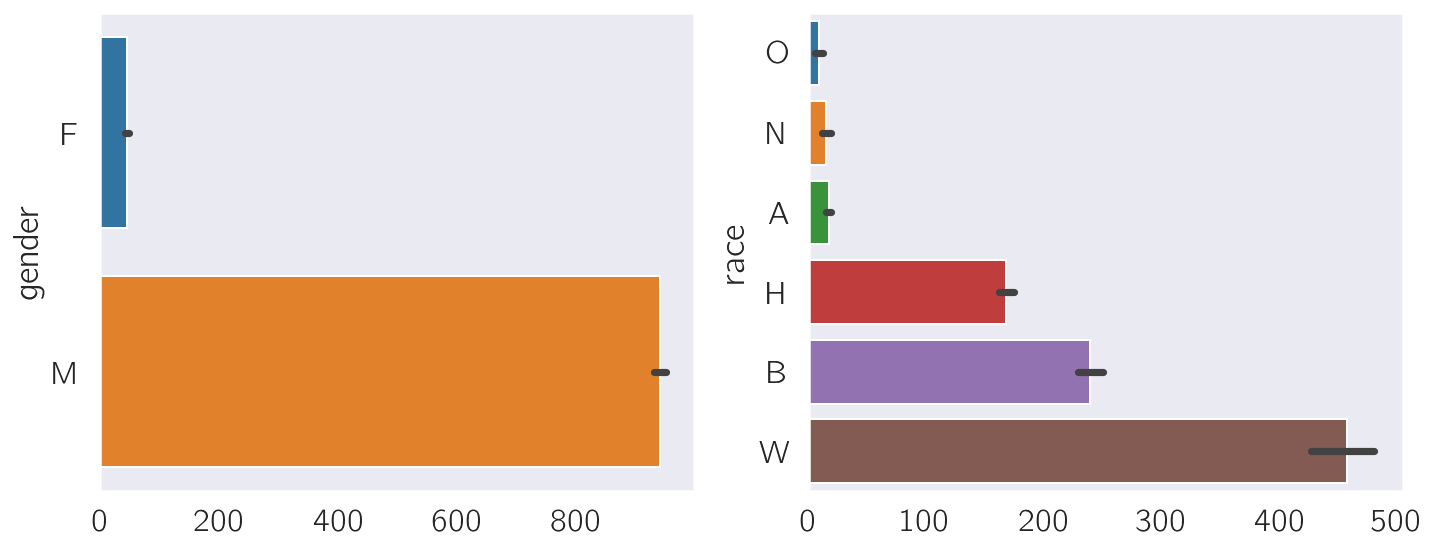

In [2]:
f = 'YS'

# fetch WaPo data:
url = 'https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv'
df = pd.read_csv(url, parse_dates=['date'])
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)
us_state_abbrev = { 'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ',
                    'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT',
                    'Delaware': 'DE', 'District of Columbia': 'DC','Florida': 'FL', 'Georgia': 'GA',
                    'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
                    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
                    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
                    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
                    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
                    'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP',
                    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR',
                    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
                    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA',
                    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
                  }

arms = { 'gun': 'firearm', 'gun and car': 'firearm', 'guns and explosives': 'firearm',
        'gun and sword': 'firearm', 'vehicle and gun': 'firearm', 'hatchet and gun': 'firearm',
        'bayonet': 'firearm', 'gun and knife': 'firearm', 'machete and gun': 'firearm',
        'ax': 'blade', 'knife': 'blade', 'chain saw': 'blade',
        'machete': 'blade', 'hatchet': 'blade', 'straight edge razor': 'blade', 'box cutter': 'blade',
        'meat cleaver': 'blade', 'spear': 'blade', 'scissors': 'blade', 'pitchfork': 'blade',
        'samurai sword': 'blade', 'cordless drill': 'blade', 'chainsaw': 'blade', 'ice pick': 'blade',
        'lawn mower blade': 'blade', 'bow and arrow': 'blade', 'car knife and mace': 'blade',
        'hammer': 'blunt object', 'baseball bat': 'blunt object', 'metal pole': 'blunt object',
        'metal hand tool': 'blunt object', 'metal stick': 'blunt object', 'metal pipe': 'blunt object',
        'beer bottle': 'blunt object', 'flashlight': 'blunt object', 'pipe': 'blunt object',
        'metal object': 'blunt object', 'rock': 'blunt object', 'baton': 'blunt object',
        'walking stick': 'blunt object', 'crowbar': 'blunt object', 'shovel': 'blunt object',
        'tire iron': 'blunt object', 'wrench': 'blunt object', 'flagpole': 'blunt object',
        'air conditioner': 'blunt object', 'oar': 'blunt object', 'barstool': 'blunt object',
        'guns and explosives': 'explosives', 'fireworks': 'explosives', 'grenade': 'explosives',
        'toy weapon': 'toy', 'bean-bag gun': 'gun, non-gunpowder', 'BB gun': 'gun, non-gunpowder',
        'pellet gun': 'gun, non-gunpowder', 'nail gun': 'gun, non-gunpowder',
        'BB gun and vehicle': 'gun, non-gunpowder', 'Airsoft pistol': 'gun, non-gunpowder',
        'unarmed': 'unarmed', 'claimed to be armed': 'claimed to be armed'}

# fetch data:
pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')
pop.state = pop.state.map(us_state_abbrev)
df = df.merge(pop, left_on='state', right_on='state')
df['year'] = pd.DatetimeIndex(df.date).year
df = df[df.year != 2020]
df['abbrevArmed'] = df.armed.map(arms)

def count_by_att(attribute, df=df, year=True, popcols=False):
    tmp = df.copy()
    if year is True:
        tmp.dropna(subset=['id', attribute, 'year'], inplace=True)
        tmp['total'] = tmp.groupby([attribute, 'year']).id.transform(lambda x: len(x))
        cols = ['year', attribute, 'total']
    else:
        tmp.dropna(subset=['id', attribute], inplace=True)
        tmp['total'] = tmp.groupby(attribute).id.transform(lambda x: len(x))
        cols = [attribute, 'total']
    
    if popcols is True:
        cols = cols + [p for p in pop.columns]
    return tmp[cols].drop_duplicates().sort_values('total')

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0] = sns.barplot(x='total', y='gender', data=count_by_att('gender'), ax=ax[0])
ax[1] = sns.barplot(x='total', y='race', data=count_by_att('race'), ax=ax[1])

ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.tight_layout()

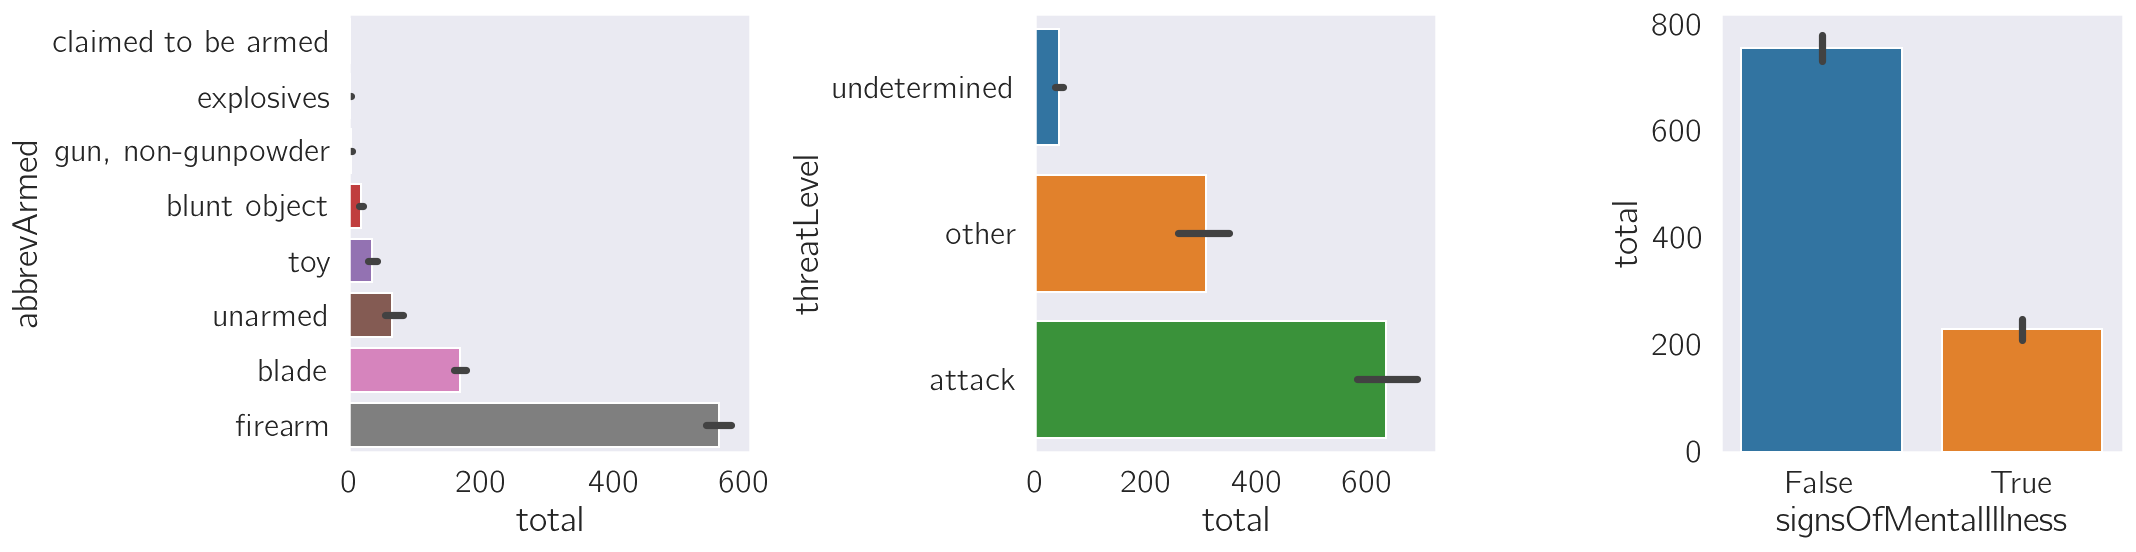

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
ax[0] = sns.barplot(x='total', y='abbrevArmed', data=count_by_att('abbrevArmed'), ax=ax[0])
ax[1] = sns.barplot(x='total', y='threatLevel', data=count_by_att('threat_level').rename({'threat_level': 'threatLevel'}, axis=1), ax=ax[1])
ax[2] = sns.barplot(y='total', x='signsOfMentalIllness',
                    data=count_by_att('signs_of_mental_illness').rename({'signs_of_mental_illness': 'signsOfMentalIllness'}, axis=1),
                    ax=ax[2])
plt.tight_layout()

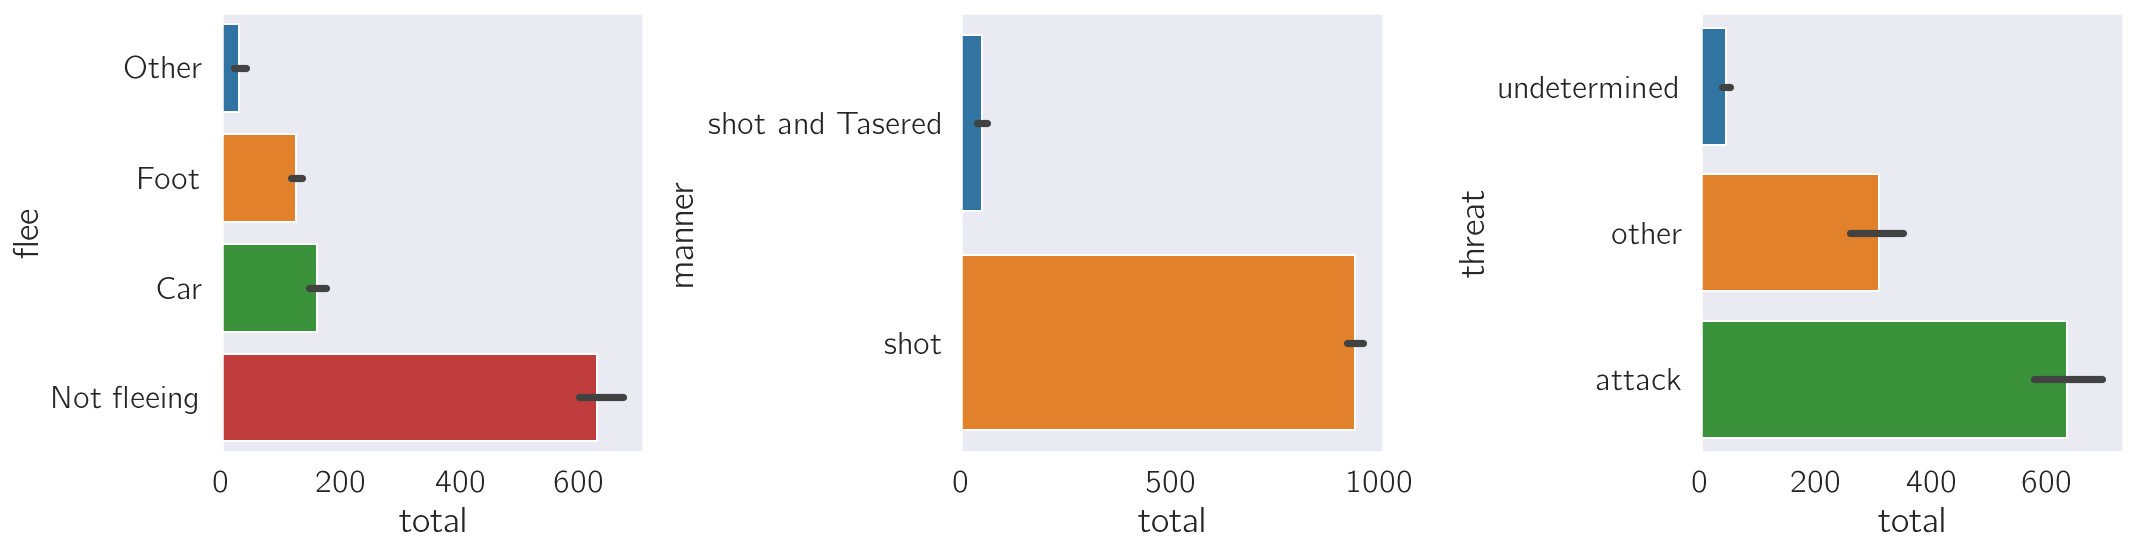

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
ax[0] = sns.barplot(x='total', y='flee', data=count_by_att('flee'), ax=ax[0])
ax[1] = sns.barplot(x='total', y='manner', data=count_by_att('manner_of_death').rename({'manner_of_death': 'manner'}, axis=1),
                    ax=ax[1])
ax[2] = sns.barplot(x='total', y='threat',
                    data=count_by_att('threat_level').rename({'threat_level': 'threat'}, axis=1),
                    ax=ax[2])
plt.tight_layout()

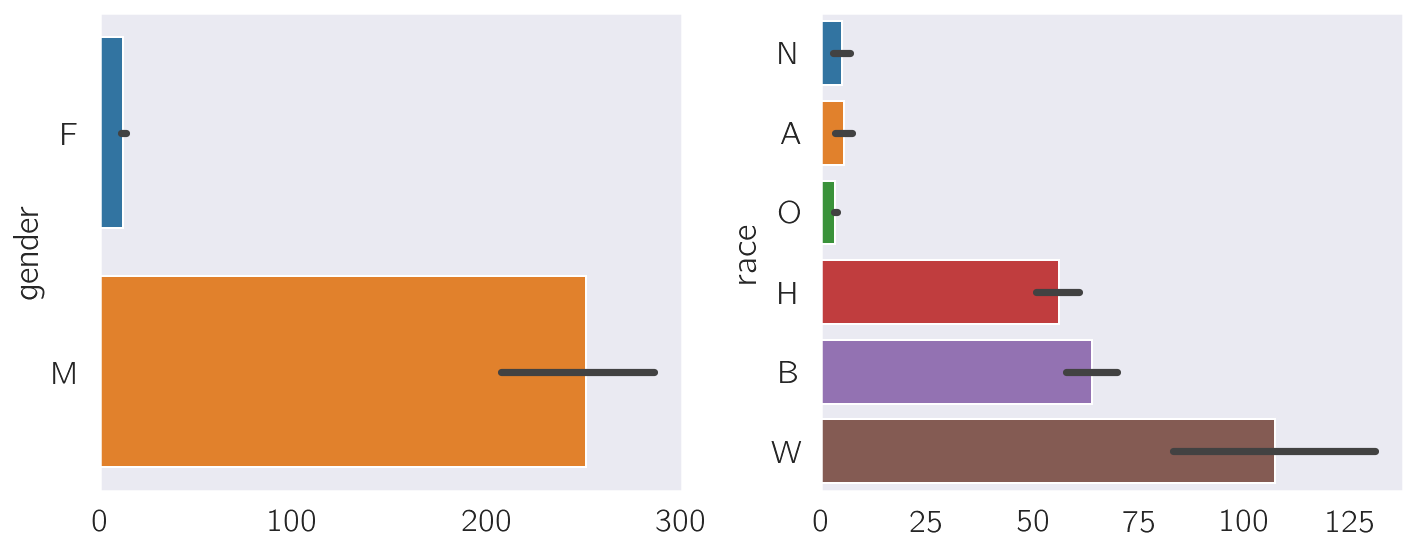

In [5]:
healthy_non_aggressive = df[(df.threat_level != 'attack') & (df.signs_of_mental_illness == False)]
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0] = sns.barplot(x='total', y='gender', data=count_by_att('gender', df=healthy_non_aggressive), ax=ax[0])
ax[1] = sns.barplot(x='total', y='race', data=count_by_att('race', df=healthy_non_aggressive), ax=ax[1])

ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.tight_layout()

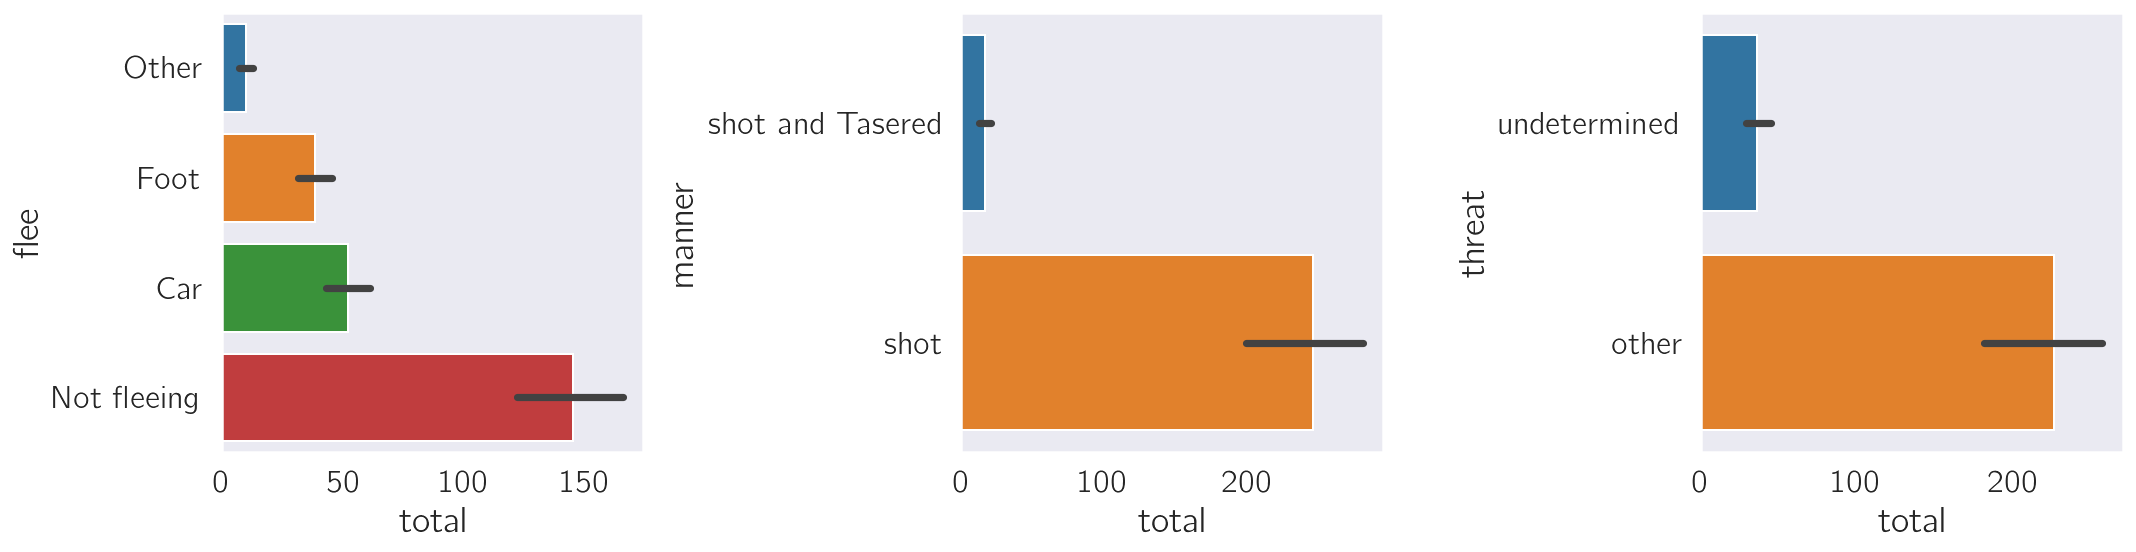

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
ax[0] = sns.barplot(x='total', y='flee', data=count_by_att('flee', df=healthy_non_aggressive), ax=ax[0])
ax[1] = sns.barplot(x='total', y='manner',
                    data=count_by_att('manner_of_death',
                                      df=healthy_non_aggressive).rename({'manner_of_death': 'manner'}, axis=1),
                    ax=ax[1])
ax[2] = sns.barplot(x='total', y='threat',
                    data=count_by_att('threat_level',
                                      df=healthy_non_aggressive).rename({'threat_level': 'threat'}, axis=1),
                    ax=ax[2])
plt.tight_layout()

In [7]:
f = 'M'
deaths_by_f = df.groupby(pd.Grouper(key='date', freq=f)).id.count().values
dates = df.groupby(pd.Grouper(key='date', freq=f)).id.count().index.values
season = pd.DataFrame(list(zip(deaths_by_f, dates)), columns=['Deaths', 'Date'])

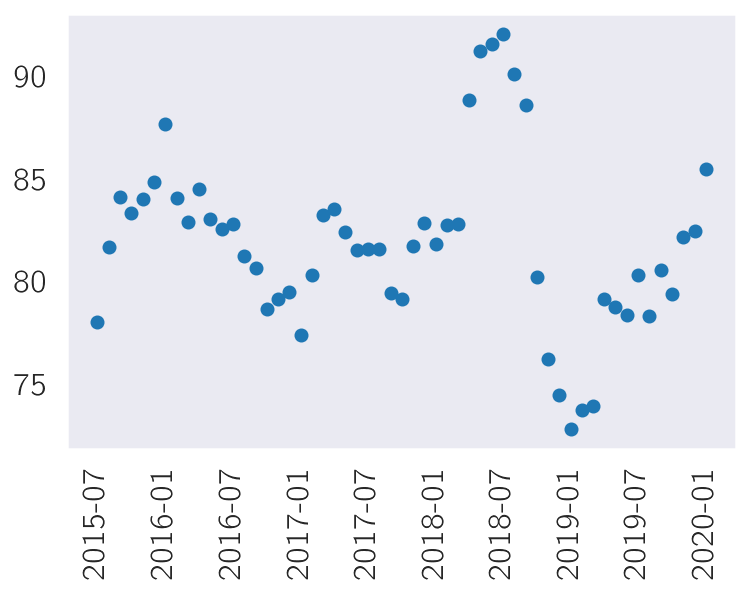

In [8]:
f = 'W'
window = 6
tau = 10
season['RefTime'] = season.groupby(pd.Grouper(key='Date',freq='YS')).Date.transform(lambda x:
                                         (x - x.min()) / dt.timedelta(days=1))
season['Smooth'] = season.Deaths.rolling(window=window, win_type='exponential').mean(tau=tau)

plt.plot(season.Date, season.Smooth, 'o')
_ = plt.xticks(rotation=90)

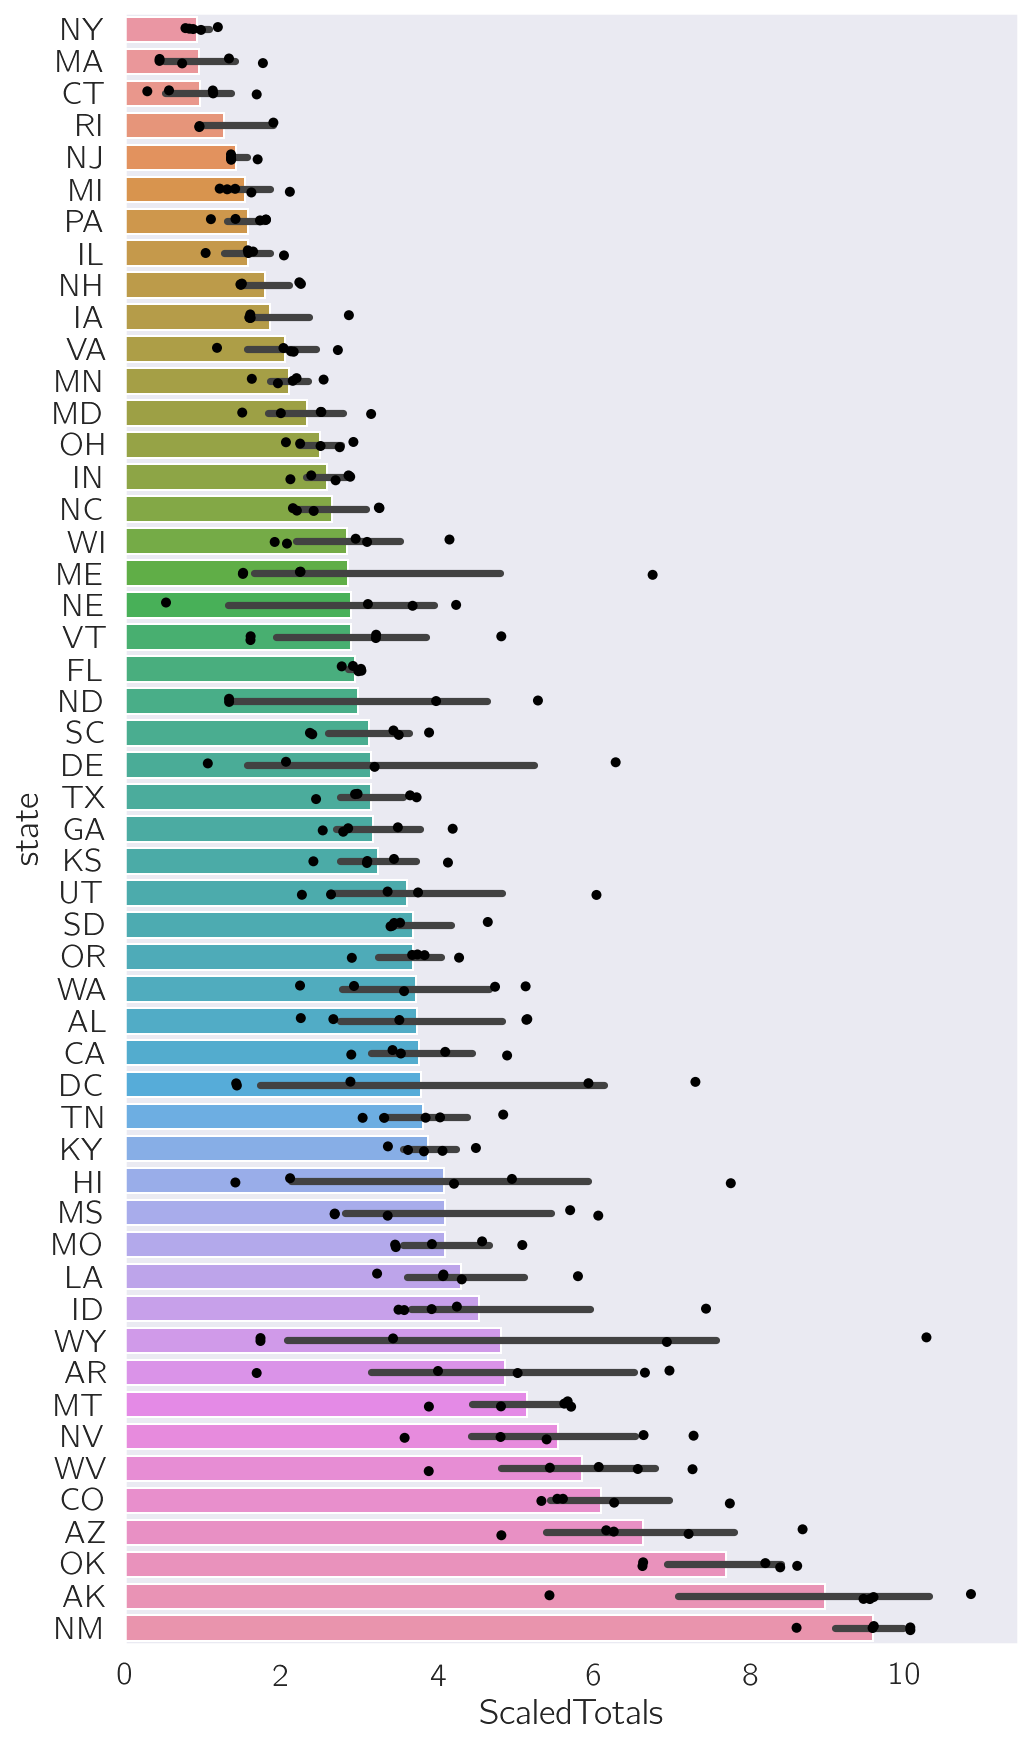

In [9]:
df['state_totals_per_year'] = df.groupby(['state', 'year']).id.transform(lambda x: x.count())
tmp = df[['state', 'year', 'state_totals_per_year', 2015, 2016, 2017, 2018, 2019]].drop_duplicates()

def norm_factor(state, year):
    if year in pop.columns:
        return pop[(pop.state == state)][year].values[0]
    else:
        return np.nan

tmp['norm_factor'] = tmp.apply(lambda x: norm_factor(x.state, x.year), axis=1)
tmp['scaled_totals'] = 10 ** 6 * tmp.state_totals_per_year / tmp.norm_factor
tmp['mean'] = tmp.groupby('state').scaled_totals.transform(np.mean)

fig, ax = plt.subplots(figsize=(8, 15))
sns.barplot(x='ScaledTotals', y='state',
            data=tmp.sort_values('mean').rename(columns={'scaled_totals':
                                                         'ScaledTotals'}))
sns.stripplot(x='ScaledTotals', y='state',
            data=tmp.sort_values('mean').rename(columns={'scaled_totals':
                                                         'ScaledTotals'}), color='black')

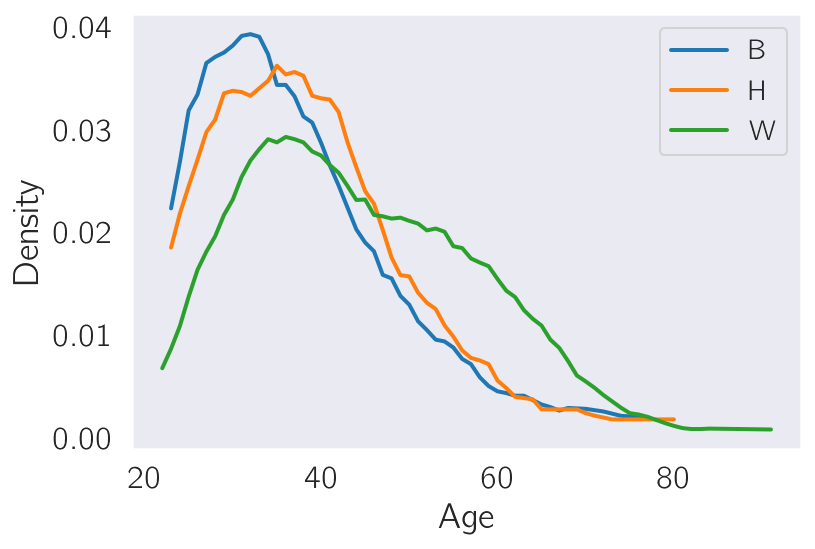

In [10]:
for n, g in df.groupby('race'):
    tmp = count_by_att('age', df=g, year=False).sort_values('age')
    
    # skip None's
    if n is 'N':
        continue
    # skip small data races:
    if tmp.total.sum() < 100:
        continue

    y = tmp.total / tmp.total.sum()
    plt.plot(tmp.age, y.rolling(10).mean(), label=n)

plt.legend()
plt.ylabel('Density')
_ = plt.xlabel('Age')